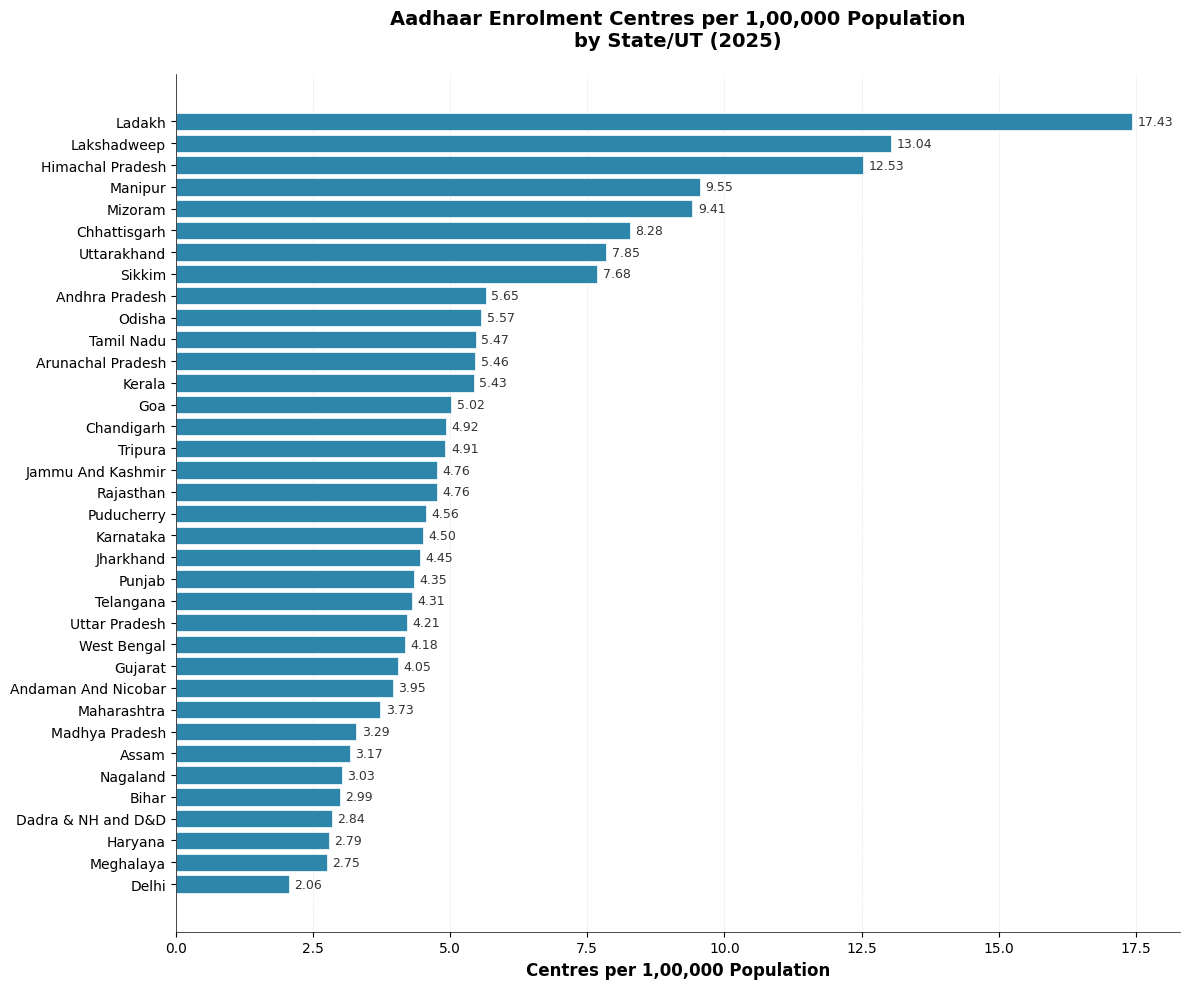

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt


centres = pd.read_excel("../sql/data/Aadhar.xlsx")
population = pd.read_excel("../sql/data/Population of Indian states 2025.xlsx")


centres = centres.rename(columns={
    "State": "state",
    "No. of centres": "centres"
})

population = population.rename(columns={
    "State/UT": "state",
    "Population 2025": "population"
})


centres["centres"] = pd.to_numeric(centres["centres"], errors="coerce")
population["population"] = (
    population["population"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(int)
)


def normalize_state(s):
    normalized = (
        s.astype(str)
        .str.strip()
        .str.lower()
        .str.replace("&", "and", regex=False)
        .str.replace(r"\s+", " ", regex=True)
    )
    
    
    normalized = normalized.str.replace(" islands", "", regex=False)
    normalized = normalized.str.replace("dadra nagar haveli", "dadra and nagar haveli", regex=False)
    
   
    normalized = normalized.str.replace("arunanchal pradesh", "arunachal pradesh", regex=False)
    
    return normalized

centres["state"] = normalize_state(centres["state"])
population["state"] = normalize_state(population["state"])


population = population[population["state"] != "india"]


df = centres.merge(population, on="state", how="inner")


unmatched_centres = set(centres["state"]) - set(df["state"])
unmatched_population = set(population["state"]) - set(df["state"])

if unmatched_centres:
    print(f"Unmatched from centres data: {unmatched_centres}")
if unmatched_population:
    print(f"Unmatched from population data: {unmatched_population}")


df = df.dropna(subset=["centres", "population"])
df = df[df["population"] > 0]


df["centres_per_1_lakh"] = (df["centres"] / df["population"]) * 100000


df = df.sort_values("centres_per_1_lakh", ascending=False)


df["state_display"] = df["state"].str.title()
df["state_display"] = df["state_display"].str.replace(
    "Dadra And Nagar Haveli And Daman And Diu", 
    "Dadra & NH and D&D", 
    regex=False
)


fig, ax = plt.subplots(figsize=(12, 10))


bars = ax.barh(df["state_display"], df["centres_per_1_lakh"], 
               color='#2E86AB', edgecolor='white', linewidth=0.5)


ax.set_xlabel("Centres per 1,00,000 Population", fontsize=12, fontweight='bold')
ax.set_title("Aadhaar Enrolment Centres per 1,00,000 Population\nby State/UT (2025)", 
             fontsize=14, fontweight='bold', pad=20)


ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)


for i, (idx, row) in enumerate(df.iterrows()):
    ax.text(row["centres_per_1_lakh"] + 0.1, i, f'{row["centres_per_1_lakh"]:.2f}', 
            va='center', fontsize=9, color='#333')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()